## Bring in libraries and dataframes and set indexes

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import matplotlib.dates as mdates
import GraphHelpers as GH

In [2]:
ObsData = pd.read_pickle('.\DataFrames\SoilVWC.pkl')
#ObsData.columns = ObsData.columns.droplevel([3,4,5,6,7,8,10])
#ObsData = ObsData.reorder_levels(['Depth','Irrigation','Nitrogen','Block'],axis=1)
ObsData.sort_index(axis=0,inplace=True)
ObsData.sort_index(axis=1,inplace=True)
#Set up factorLevel descriptors
Depths = ObsData.columns.get_level_values(0).drop_duplicates().values
F1 = ObsData.columns.get_level_values(1).drop_duplicates().values
F2 = ObsData.columns.get_level_values(2).drop_duplicates().values
Blocks = ObsData.columns.get_level_values(3).drop_duplicates().values

In [3]:
GPs = GH.SetGraphicsPatterns(ObsData.D1B.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

Start = ObsData.index.min()
End = ObsData.index.max()

Irrigation
['Dryland', 'Irrigated']
Nitrogen
['0', '250', '50']
Treatments
MultiIndex(levels=[['Dryland', 'Irrigated'], ['0', '250', '50']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
              Lin     Col   Alp Mar     MFC
Dryland   0     -  orange  0.15   o  orange
          250   -   green  0.15   o   green
          50    -  purple  0.15   o  purple
Irrigated 0    --  orange  0.45   ^   white
          250  --   green  0.45   ^   white
          50   --  purple  0.45   ^   white


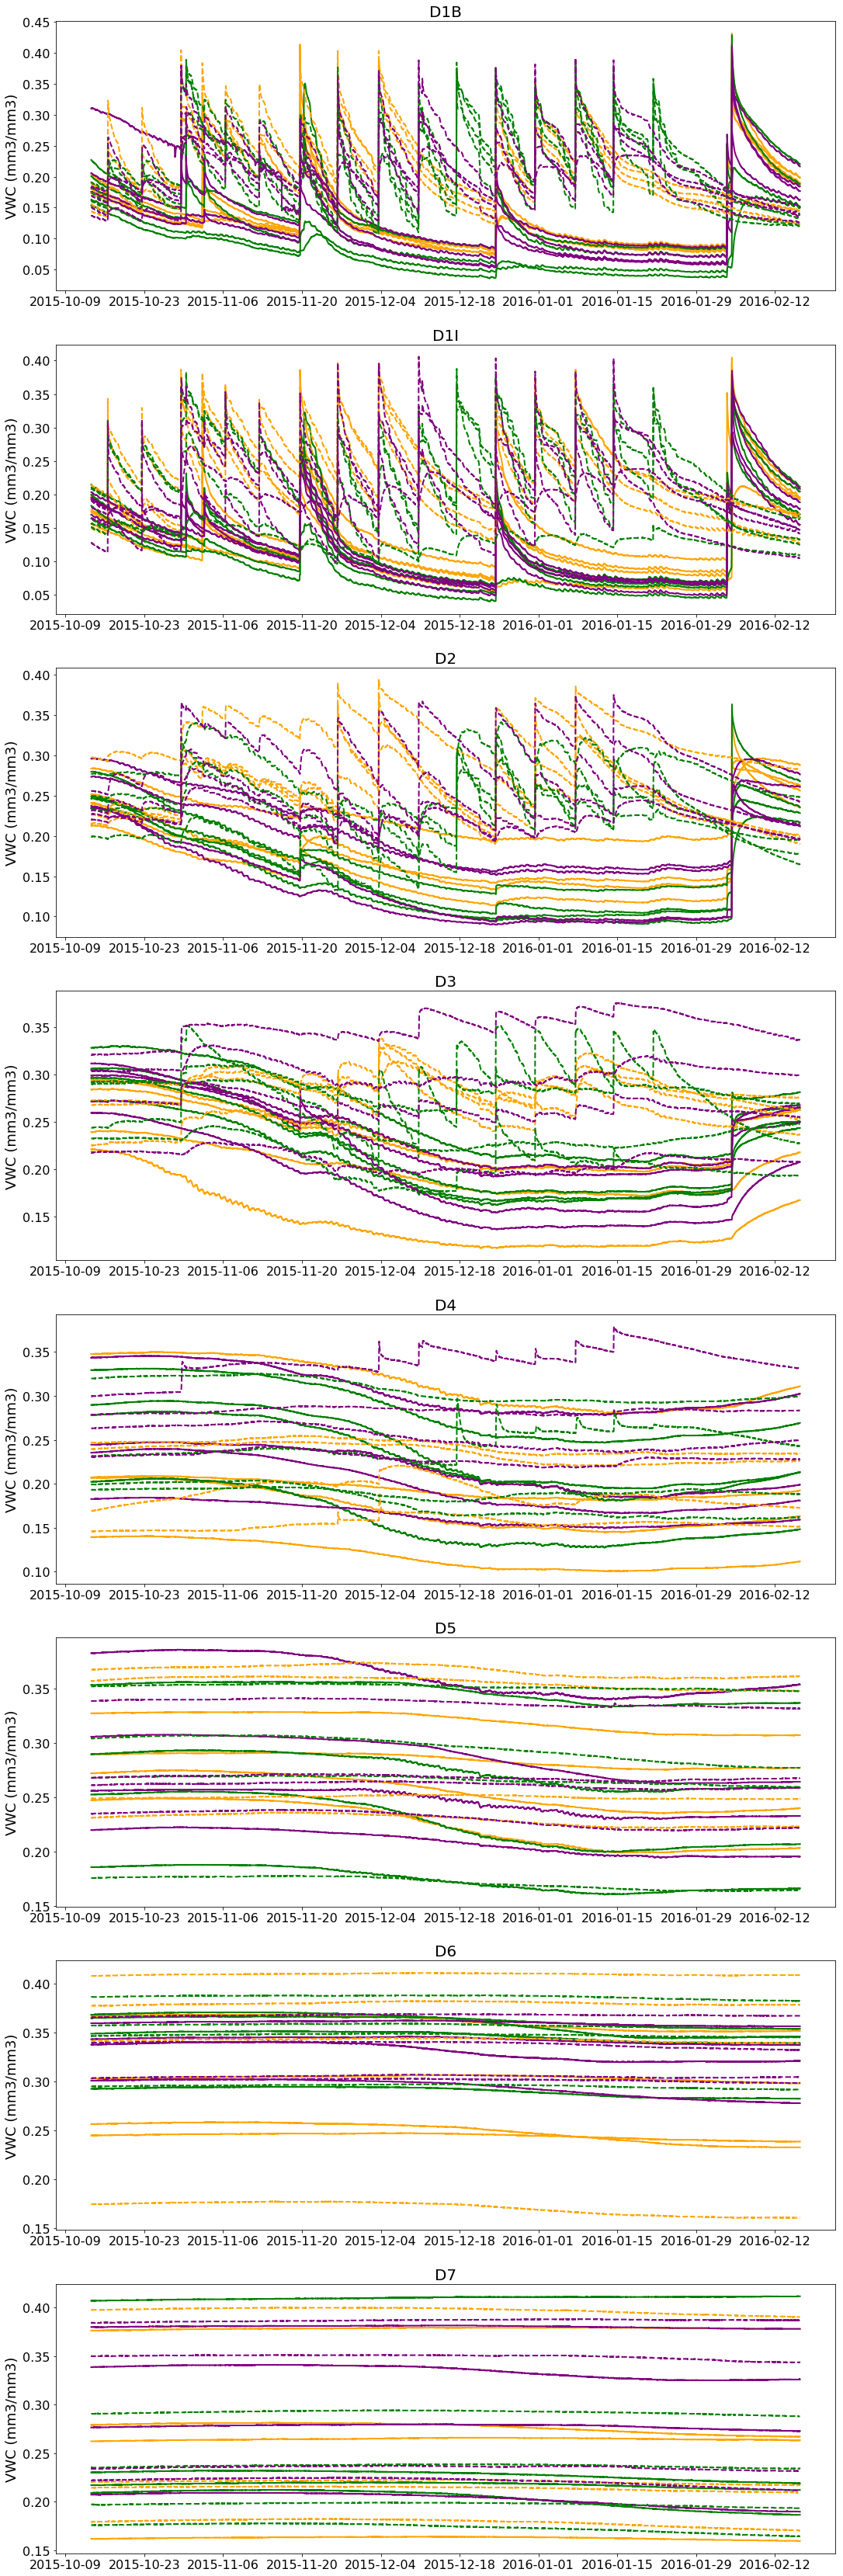

In [4]:
Graph = plt.figure(figsize=(18,60))
pos = 1
for D in Depths:
    ax = Graph.add_subplot(8,1,pos)
    GH.AddIndexedPlot(ObsData.loc[:,D],ax,GPs,2)
    plt.title(D,fontsize=20)
    plt.tick_params(labelsize=16)
    plt.ylabel('VWC (mm3/mm3)',fontsize=18)
    pos +=1

In [35]:
ColumnFilter = ObsData.columns.isin(['Dryland'],level=1) & ObsData.columns.isin(['250'],level=2)

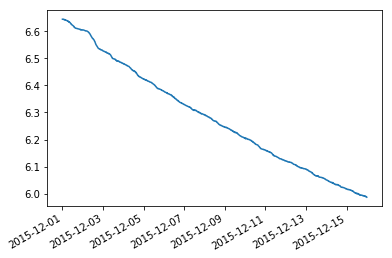

In [39]:
ObsData.loc['2015-12-1':'2015-12-15',ColumnFilter].sum(axis=1).plot()

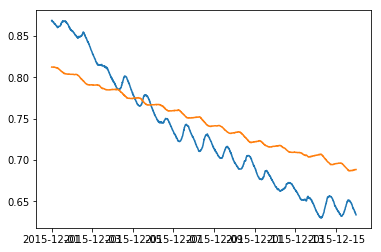

In [45]:
plt.plot(ObsData.D1B.Dryland.loc['2015-12-1':'2015-12-15','250'].mean(axis=1)/.1)
plt.plot(ObsData.D4.Dryland.loc['2015-12-1':'2015-12-15','250'].mean(axis=1)/.3)

## There is a problem with one sensor in the top layer

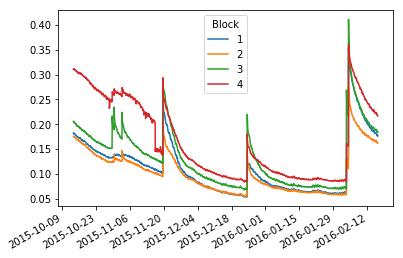

In [5]:
ObsData.loc[:,('D1B','Dryland','50')].plot()

## Block 4 for 50kg Dryland
Set the dodgy data to nan

In [6]:
ObsData.loc[:'2015-11-19',('D1B','Dryland','50','4')] = np.nan

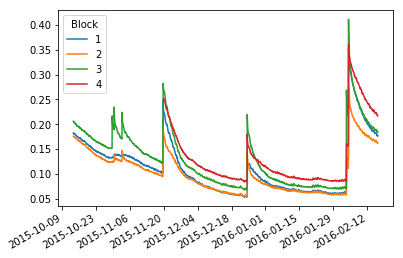

In [7]:
ObsData.loc[:,('D1B','Dryland','50')].plot()

## Calculate soil water deficit

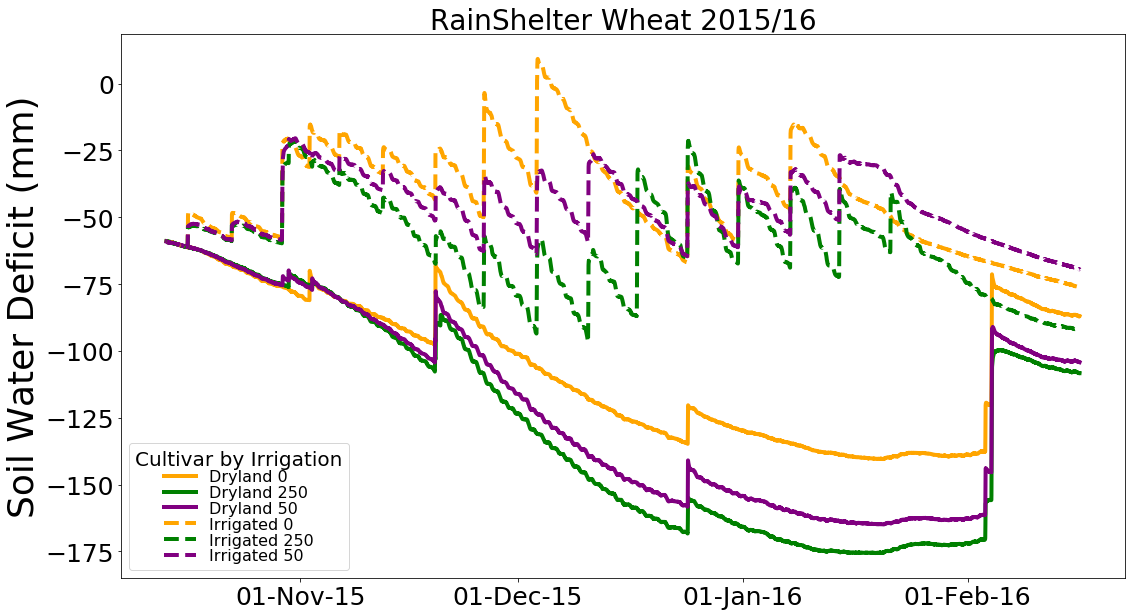

In [8]:
#Calculate treatment means omitting data prior to 2014-11-05 08:00:00 to avoid NaN values
DataMeans =  ObsData.groupby(level=['Depth','Irrigation', 'Nitrogen'],axis=1).mean()

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater = DataMeans.loc[:,'D1I'] * 150/2 + \
               DataMeans.loc[:,'D1B'] * 150/2 + \
               DataMeans.loc[:,'D2'] * 150 + \
               DataMeans.loc[:,'D3'] * 300 + \
               DataMeans.loc[:,'D4'] * 300 + \
               DataMeans.loc[:,'D5'] * 300 + \
               DataMeans.loc[:,'D6'] * 300 + \
               DataMeans.loc[:,'D7'] * 300
                
FieldCapacity = ProfileWater.resample('D').max()
FieldCapacity = FieldCapacity.loc['2015-10-15'] + 60  # I would have though this would return a data frame with a single row but instead it returns a series with a multiindex in columns
SoilWaterDeficit = -(FieldCapacity - ProfileWater)    # This calculation only works because field capacity is a multi index series
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(SoilWaterDeficit,ax,GPs,4)
plt.ylabel('Soil Water Deficit (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Wheat 2015/16', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(20)

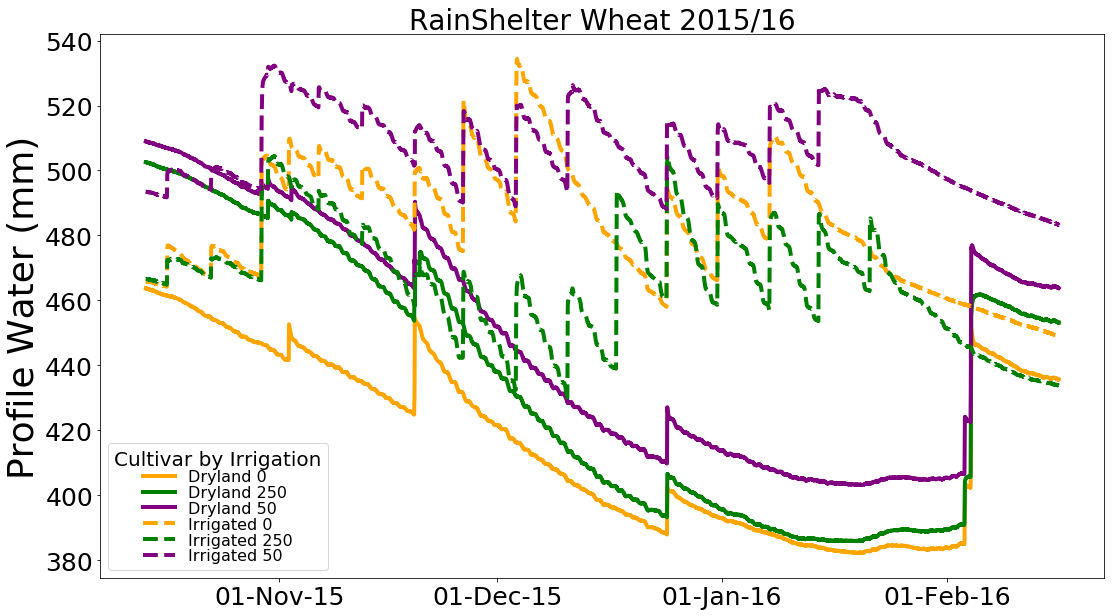

In [9]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(ProfileWater,ax,GPs,4)
plt.ylabel('Profile Water (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Wheat 2015/16', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(20)

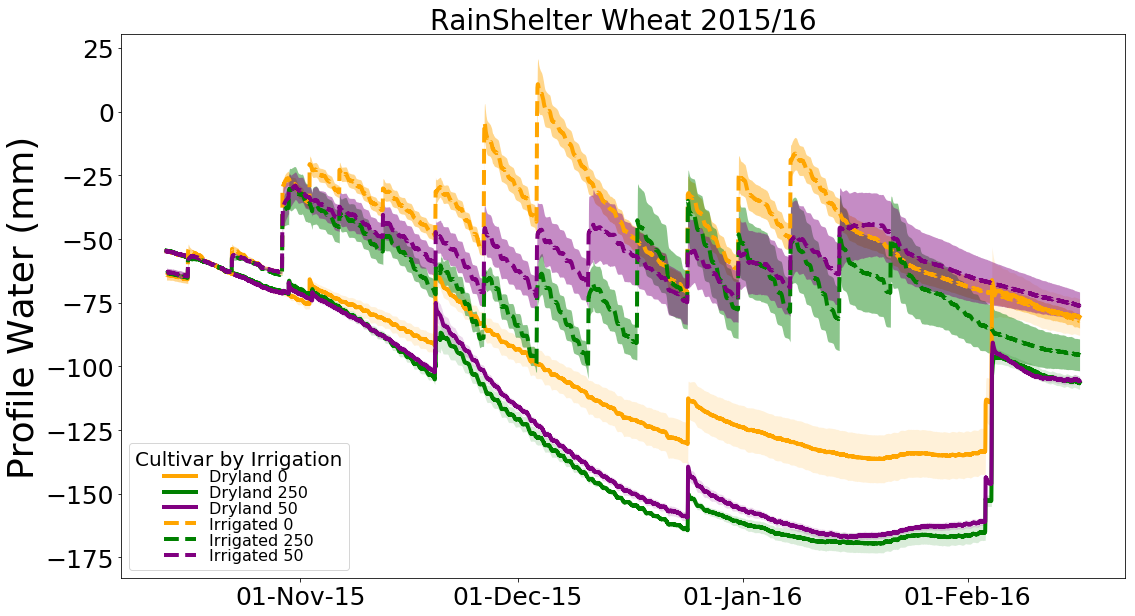

In [10]:
DataMeans2 = ObsData.groupby(level=['Depth', 'Irrigation', 'Nitrogen','Block'],axis=1).mean()
DataMeans2 =  DataMeans2.dropna(axis=1, how = 'all')

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater2 = DataMeans2.loc[:,'D1I'] * 150/2 + \
               DataMeans2.loc[:,'D1B'] *150/2 + \
               DataMeans2.loc[:,'D2'] * 150 + \
               DataMeans2.loc[:,'D3'] * 300 + \
               DataMeans2.loc[:,'D4'] * 300 + \
               DataMeans2.loc[:,'D5'] * 300 + \
               DataMeans2.loc[:,'D6'] * 300 + \
               DataMeans2.loc[:,'D7'] * 300
                
FieldCapacity2 = ProfileWater2.resample('D').max()
FieldCapacity2 = FieldCapacity2.loc['2015-10-20'] + 60
SoilWaterDeficit2 = -(FieldCapacity2 - ProfileWater2)

Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlotWithSEM(SoilWaterDeficit2,ax,GPs,4)
plt.ylabel('Profile Water (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Wheat 2015/16', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(20)

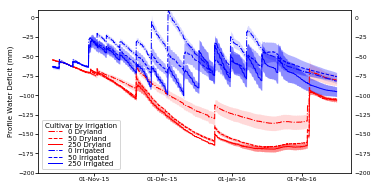

In [11]:
DataMeans2 = ObsData.groupby(level=['Depth', 'Irrigation', 'Nitrogen','Block'],axis=1).mean()
DataMeans2 =  DataMeans2.dropna(axis=1, how = 'all')

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater2 = DataMeans2.loc[:,'D1I'] * 150/2 + \
               DataMeans2.loc[:,'D1B'] *150/2 + \
               DataMeans2.loc[:,'D2'] * 150 + \
               DataMeans2.loc[:,'D3'] * 300 + \
               DataMeans2.loc[:,'D4'] * 300 + \
               DataMeans2.loc[:,'D5'] * 300 + \
               DataMeans2.loc[:,'D6'] * 300 + \
               DataMeans2.loc[:,'D7'] * 300
                
FieldCapacity2 = ProfileWater2.resample('D').max()
FieldCapacity2 = FieldCapacity2.loc['2015-10-20'] + 60
SoilWaterDeficit2 = -(FieldCapacity2 - ProfileWater2)

Nitrogens = ['0','50','250']
Irrigations = ['Dryland', 'Irrigated']
lines = ['-.','--','-']
gaps = [3,0.000001]
colors = ['r','b']
alphas = [0.15,0.3,0.45]

Graph = plt.figure(figsize=(5.6,3))
fig = Graph.add_subplot(1,1,1)
IrrPos = 0
for Irr in Irrigations:
    NPos = 0
    for N in Nitrogens:
        Ind = SoilWaterDeficit2.loc[:,(Irr,N)].index
        Med = SoilWaterDeficit2.loc[:,(Irr,N)].median(axis=1)
        SEM = SoilWaterDeficit2.loc[:,(Irr,N)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=alphas[NPos],lw=0)
        plt.plot(Ind,Med,lines[NPos],color=colors[IrrPos], linewidth = 1,label = N + ' ' + Irr)
        NPos += 1
    IrrPos+=1

    plt.ylabel('Profile Water Deficit (mm)', fontsize=7)
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=True,labelsize=6, length = 3, direction = 'out', pad = 1)
        
#     ledg = plt.legend(loc=3,numpoints=1,fontsize = 24,labelspacing = 0.05, 
#                       title='Treatment')
#     ledg.get_title().set_fontsize(28)
#     ledg.get_title().set_weight('bold')
plt.ylim(-200,10)
# plt.xlim('2014-11-01','2015-02-15')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 7,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(7)
#ledg.get_title().set_weight('bold')
plt.tight_layout
plt.savefig('Fig_1.jpg',dpi=1000)

In [12]:
DeltaWater = ProfileWater2.diff()
DeltaWater.to_pickle('.\DataFrames\ProfileWaterDelta.pkl')
SWD = SoilWaterDeficit.resample('D').mean()
SWD.to_pickle('.\DataFrames\DailySWD.pkl')